# LLMs with Hugging Face

In this notebook, we'll take a whirlwind tour of some top applications using Large Language Models (LLMs):
* Summarization
* Sentiment analysis
* Translation
* Zero-shot classification
* Few-shot learning

We will see how existing, open-source (and proprietary) models can be used out-of-the-box for many applications.  For this, we will use [Hugging Face models](https://huggingface.co/models) and some simple prompt engineering.

We will then look at Hugging Face APIs in more detail to understand how to configure LLM pipelines.

### Learning Objectives
1. Use a variety of existing models for a variety of common applications.
1. Understand basic prompt engineering.
1. Understand search vs. sampling for LLM inference.
1. Get familiar with the main Hugging Face abstractions: datasets, pipelines, tokenizers, and models.

## Enviroment setup

In [1]:
# Conda environment - python3.9
# !conda create -n llm python=3.9 && conda activate llm

In [2]:
# import os
# import urllib3

# # SSL
# urllib3.disable_warnings(urllib3.exceptions.InsecureRequestWarning)
# os.environ['CURL_CA_BUNDLE'] = ''

# # Proxy
# http_proxy = 'http://localhost:3128'
# os.environ['http_proxy'] = http_proxy
# os.environ['https_proxy'] = http_proxy
# os.environ['HTTP_PROXY'] = http_proxy
# os.environ['HTTPS_PROXY'] = http_proxy

In [3]:
# Install pip requirements
!which python3

!cat requirements.txt
!python3 -m pip install -r requirements.txt

/home/dev-vm/anaconda3/envs/hoangph3/bin/python3
#torch==2.0.1  # compatible with cuda-11.7, nvidia-515.43.04
accelerate
datasets==2.15.0
transformers==4.41.2
sentencepiece==0.2.0
#protobuf==5.27.1
sacremoses==0.0.53
numpy==1.26.4
faiss-cpu==1.7.4
chromadb==0.3.21
matplotlib

#requests==2.27.1

wikipedia==1.4.0
google-search-results==2.4.2
better-profanity==0.7.0
sqlalchemy==2.0.15
langchain==0.2.5
langchain-community==0.2.5
langchain-core==0.2.9
langchain-text-splitters==0.2.1
langchain-experimental
openai
tabulate
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com

[notice] A new release of pip is available: 24.0 -> 24.1
[notice] To update, run: pip install --upgrade pip


## Common LLM applications

The goal of this section is to get your feet wet with several LLM applications and to show how easy it can be to get started with LLMs.

As you go through the examples, note the datasets, models, APIs, and options used.  These simple examples can be starting points when you need to build your own application.

In [4]:
from datasets import load_dataset
from transformers import pipeline

### Summarization

Summarization can take two forms:
* `extractive`: extract the most relevant information from a document. This method selects important sentences or passages directly from the source to form a summary. It is easier to implement compared to abstractive summarization because it does not require the generation of new content.
* `abstractive`: generate new text that captures the most relevant information and may not exist in the original text. It can produce more concise and coherent summaries, but it is generally more challenging to implement compared to extractive method.

Here, we will use a model which does *abstractive* summarization:
* **Data**: [xsum](https://huggingface.co/datasets/xsum) dataset, which provides a set of BBC articles and summaries.
* **Model**: [t5-small](https://huggingface.co/t5-small) model, which has 60 million parameters (242MB for PyTorch).  T5 is an encoder-decoder model created by Google which supports several tasks such as summarization, translation, Q&A, and text classification.  For more details, see the [Google blog post](https://ai.googleblog.com/2020/02/exploring-transfer-learning-with-t5.html), [code on GitHub](https://github.com/google-research/text-to-text-transfer-transformer), or the [research paper](https://arxiv.org/pdf/1910.10683.pdf).

In [5]:
# Load predownloaded dataset from local
xsum_dataset = load_dataset(
    "xsum", version="1.2.0", cache_dir="../working/cache/"
)
print(xsum_dataset)

DatasetDict({
    train: Dataset({
        features: ['document', 'summary', 'id'],
        num_rows: 204045
    })
    validation: Dataset({
        features: ['document', 'summary', 'id'],
        num_rows: 11332
    })
    test: Dataset({
        features: ['document', 'summary', 'id'],
        num_rows: 11334
    })
})


This dataset provides 3 columns:
* `document`: the BBC article text
* `summary`: a "ground-truth" summary --> Note how subjective this "ground-truth" is.  Is this the same summary you would write?  This a great example of how many LLM applications do not have obvious "right" answers.
* `id`: article ID

In [6]:
xsum_sample = xsum_dataset["train"].select(range(10))
xsum_df = xsum_sample.to_pandas()
display(xsum_df)

idx = 0
print("Document:", xsum_sample['document'][0])
print()
print("Summary:", xsum_sample['summary'][0])

,document,summary,id
0,"The full cost of damage in Newton Stewart, one...",Clean-up operations are continuing across the ...,35232142
1,A fire alarm went off at the Holiday Inn in Ho...,Two tourist buses have been destroyed by fire ...,40143035
2,Ferrari appeared in a position to challenge un...,Lewis Hamilton stormed to pole position at the...,35951548
3,"John Edward Bates, formerly of Spalding, Linco...",A former Lincolnshire Police officer carried o...,36266422
4,Patients and staff were evacuated from Cerahpa...,An armed man who locked himself into a room at...,38826984
5,Simone Favaro got the crucial try with the las...,Defending Pro12 champions Glasgow Warriors bag...,34540833
6,"Veronica Vanessa Chango-Alverez, 31, was kille...",A man with links to a car that was involved in...,20836172
7,Belgian cyclist Demoitie died after a collisio...,Welsh cyclist Luke Rowe says changes to the sp...,35932467
8,"Gundogan, 26, told BBC Sport he ""can see the f...",Manchester City midfielder Ilkay Gundogan says...,40758845
9,The crash happened about 07:20 GMT at the junc...,A jogger has been hit by an unmarked police ca...,30358490


Document: The full cost of damage in Newton Stewart, one of the areas worst affected, is still being assessed.
Repair work is ongoing in Hawick and many roads in Peeblesshire remain badly affected by standing water.
Trains on the west coast mainline face disruption due to damage at the Lamington Viaduct.
Many businesses and householders were affected by flooding in Newton Stewart after the River Cree overflowed into the town.
First Minister Nicola Sturgeon visited the area to inspect the damage.
The waters breached a retaining wall, flooding many commercial properties on Victoria Street - the main shopping thoroughfare.
Jeanette Tate, who owns the Cinnamon Cafe which was badly affected, said she could not fault the multi-agency response once the flood hit.
However, she said more preventative work could have been carried out to ensure the retaining wall did not fail.
"It is difficult but I do think there is so much publicity for Dumfries and the Nith - and I totally appreciate that - bu

We next use the Hugging Face `pipeline` tool to load a pre-trained model.  In this LLM pipeline constructor, we specify:
* `task`: This first argument specifies the primary task.  See [Hugging Face tasks](https://huggingface.co/tasks) for more information.
* `model`: This is the name of the pre-trained model from the [Hugging Face Hub](https://huggingface.co/models).
* `min_length`, `max_length`: We want our generated summaries to be between these two token lengths.
* `truncation`: Some input articles may be too long for the LLM to process.  Most LLMs have fixed limits on the length of input sequences.  This option tells the pipeline to truncate the input if needed.

In [7]:
summarizer = pipeline(
    task="summarization",
    model="t5-small",
    min_length=20,
    max_length=40,
    truncation=True,
    model_kwargs={"cache_dir": "../working/cache/"},
    device='cuda:0',
    # device_map='auto'
)  # Note: We specify cache_dir to use predownloaded models.

In [8]:
# Apply to 1 article
summarizer(xsum_sample["document"][0])

[{'summary_text': 'the full cost of damage in Newton Stewart is still being assessed . many roads in peeblesshire remain badly affected by standing water . a flood alert remains in place across the'}]

In [9]:
# Apply to a batch of articles
results = summarizer(xsum_sample["document"])

In [10]:
# Display the generated summary side-by-side with the reference summary and original document.
# We use Pandas to join the inputs and outputs together in a nice format.
import pandas as pd

display(
    pd.DataFrame.from_dict(results)
    .rename({"summary_text": "generated_summary"}, axis=1)
    .join(pd.DataFrame.from_dict(xsum_sample))[
        ["generated_summary", "summary", "document"]
    ]
)

,generated_summary,summary,document
0,the full cost of damage in Newton Stewart is s...,Clean-up operations are continuing across the ...,"The full cost of damage in Newton Stewart, one..."
1,a fire alarm went off at the Holiday Inn in Ho...,Two tourist buses have been destroyed by fire ...,A fire alarm went off at the Holiday Inn in Ho...
2,Sebastian Vettel will start third ahead of tea...,Lewis Hamilton stormed to pole position at the...,Ferrari appeared in a position to challenge un...
3,the 67-year-old is accused of committing the o...,A former Lincolnshire Police officer carried o...,"John Edward Bates, formerly of Spalding, Linco..."
4,a man receiving psychiatric treatment at the c...,An armed man who locked himself into a room at...,Patients and staff were evacuated from Cerahpa...
5,Gregor Townsend gave a debut to powerhouse win...,Defending Pro12 champions Glasgow Warriors bag...,Simone Favaro got the crucial try with the las...
6,"Veronica Vanessa Chango-Alverez, 31, was kille...",A man with links to a car that was involved in...,"Veronica Vanessa Chango-Alverez, 31, was kille..."
7,the 25-year-old was hit by a motorbike during ...,Welsh cyclist Luke Rowe says changes to the sp...,Belgian cyclist Demoitie died after a collisio...
8,gundogan will not be fit for the start of the ...,Manchester City midfielder Ilkay Gundogan says...,"Gundogan, 26, told BBC Sport he ""can see the f..."
9,the crash happened about 07:20 GMT at the junc...,A jogger has been hit by an unmarked police ca...,The crash happened about 07:20 GMT at the junc...


### Sentiment analysis

Sentiment analysis is a text classification task of estimating whether a piece of text is positive, negative, or another "sentiment" label.  The precise set of sentiment labels can vary across applications.

In this section, we will use:
* **Data**: [poem sentiment](https://huggingface.co/datasets/poem_sentiment) dataset, which provides lines from poems tagged with sentiments `negative` (0), `positive` (1), `no_impact` (2), or `mixed` (3).
* **Model**: [fine-tuned version of BERT](https://huggingface.co/nickwong64/bert-base-uncased-poems-sentiment).  BERT, or Bidirectional Encoder Representations from Transformers, is an encoder-only model from Google usable for 11+ tasks such as sentiment analysis and entity recognition.  For more details, see this [Hugging Face blog post](https://huggingface.co/blog/bert-101) or the [Wikipedia page](https://en.wikipedia.org/wiki/BERT_&#40;language_model&#41;).

In [13]:
poem_dataset = load_dataset(
    "poem_sentiment", version="1.0.0", cache_dir="../working/cache/"
)
poem_sample = poem_dataset["train"].select(range(10))
display(poem_sample.to_pandas())

,id,verse_text,label
0,0,with pale blue berries. in these peaceful shad...,1
1,1,"it flows so long as falls the rain,",2
2,2,"and that is why, the lonesome day,",0
3,3,"when i peruse the conquered fame of heroes, an...",3
4,4,of inward strife for truth and liberty.,3
5,5,the red sword sealed their vows!,3
6,6,and very venus of a pipe.,2
7,7,"who the man, who, called a brother.",2
8,8,"and so on. then a worthless gaud or two,",0
9,9,to hide the orb of truth--and every throne,2


We load the pipeline using the task `text-classification` since we want to classify text with a fixed set of labels.

In [14]:
sentiment_classifier = pipeline(
    task="text-classification",
    model="nickwong64/bert-base-uncased-poems-sentiment",
    model_kwargs={"cache_dir": "../working/cache/"},
    device='cuda:0'
)

In [17]:
results = sentiment_classifier(poem_sample["verse_text"])
display(results)

[{'label': 'positive', 'score': 0.9965937733650208},
 {'label': 'no_impact', 'score': 0.9987409710884094},
 {'label': 'negative', 'score': 0.995965838432312},
 {'label': 'mixed', 'score': 0.9687354564666748},
 {'label': 'mixed', 'score': 0.9759674668312073},
 {'label': 'mixed', 'score': 0.9665797352790833},
 {'label': 'no_impact', 'score': 0.9986388087272644},
 {'label': 'no_impact', 'score': 0.9986108541488647},
 {'label': 'negative', 'score': 0.9965572357177734},
 {'label': 'no_impact', 'score': 0.9985186457633972}]

In [18]:
# Display the predicted sentiment side-by-side with the ground-truth label and original text.
# The score indicates the model's confidence in its prediction.

# Join predictions with ground-truth data
joined_data = (
    pd.DataFrame.from_dict(results)
    .rename({"label": "predicted_label"}, axis=1)
    .join(pd.DataFrame.from_dict(poem_sample).rename({"label": "true_label"}, axis=1))
)

# Change label indices to text labels
sentiment_labels = {0: "negative", 1: "positive", 2: "no_impact", 3: "mixed"}
joined_data = joined_data.replace({"true_label": sentiment_labels})

display(joined_data[["predicted_label", "true_label", "score", "verse_text"]])

,predicted_label,true_label,score,verse_text
0,positive,positive,0.996594,with pale blue berries. in these peaceful shad...
1,no_impact,no_impact,0.998741,"it flows so long as falls the rain,"
2,negative,negative,0.995966,"and that is why, the lonesome day,"
3,mixed,mixed,0.968735,"when i peruse the conquered fame of heroes, an..."
4,mixed,mixed,0.975967,of inward strife for truth and liberty.
5,mixed,mixed,0.966580,the red sword sealed their vows!
6,no_impact,no_impact,0.998639,and very venus of a pipe.
7,no_impact,no_impact,0.998611,"who the man, who, called a brother."
8,negative,negative,0.996557,"and so on. then a worthless gaud or two,"
9,no_impact,no_impact,0.998519,to hide the orb of truth--and every throne


### Translation

Translation models may be designed for specific pairs of languages, or they may support more than two languages.  We will see both below.

In this section, we will use:
* **Data**: We will use some example hard-coded sentences.  However, there are a variety of [translation datasets](https://huggingface.co/datasets?task_categories=task_categories:translation&sort=downloads) available from Hugging Face.
* **Models**:
   * [Helsinki-NLP/opus-mt-en-es](https://huggingface.co/Helsinki-NLP/opus-mt-en-es) is used for the first example of English ("en") to Spanish ("es") translation.  This model is based on [Marian NMT](https://marian-nmt.github.io/), a neural machine translation framework developed by Microsoft and other researchers.  See the [GitHub page](https://github.com/Helsinki-NLP/Opus-MT) for code and links to related resources.
   * [t5-small](https://huggingface.co/t5-small) model, which has 60 million parameters (242MB for PyTorch).  T5 is an encoder-decoder model created by Google which supports several tasks such as summarization, translation, Q&A, and text classification.  For more details, see the [Google blog post](https://ai.googleblog.com/2020/02/exploring-transfer-learning-with-t5.html), [code on GitHub](https://github.com/google-research/text-to-text-transfer-transformer), or the [research paper](https://arxiv.org/pdf/1910.10683.pdf).  For our purposes, it supports translation for English, French, Romanian, and German.

Some models are designed for specific language-to-language translation.  Below, we use an English-to-Spanish model.

In [19]:
en_to_es_translation_pipeline = pipeline(
    task="translation",
    model="Helsinki-NLP/opus-mt-en-es",
    model_kwargs={"cache_dir": "../working/cache/"},
    device='cuda:0'
)

config.json:   0%|          | 0.00/1.47k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/312M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/293 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/44.0 [00:00<?, ?B/s]

source.spm:   0%|          | 0.00/802k [00:00<?, ?B/s]

target.spm:   0%|          | 0.00/826k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.59M [00:00<?, ?B/s]

In [20]:
en_to_es_translation_pipeline(
    "Existing, open-source (and proprietary) models can be used out-of-the-box for many applications."
)

[{'translation_text': 'Los modelos existentes, de código abierto (y propietario) se pueden utilizar fuera de la caja para muchas aplicaciones.'}]

Other models are designed to handle multiple languages.  Below, we show this with `t5-small`.  Note that, since it supports multiple languages (and tasks), we give it an explicit instruction to translate from one language to another.

In [21]:
t5_small_pipeline = pipeline(
    task="text2text-generation",
    model="t5-small",
    max_length=50,
    model_kwargs={"cache_dir": "../working/cache/"},
)

In [22]:
t5_small_pipeline(
    "translate English to French: Existing, open-source (and proprietary) models can be used out-of-the-box for many applications."
)

[{'generated_text': 'Les modèles existants, libres (et propriétaires) peuvent être utilisés hors de la boîte de commande pour de nombreuses applications.'}]

In [23]:
t5_small_pipeline(
    "translate English to Romanian: Existing, open-source (and proprietary) models can be used out-of-the-box for many applications."
)

[{'generated_text': 'Modelele existente, deschise (şi proprietăţi) pot fi utilizate în afara legii pentru multe aplicaţii.'}]

### Zero-shot classification

Zero-shot classification (or zero-shot learning) is the task of classifying a piece of text into one of a few given categories or labels, without having explicitly trained the model to predict those categories beforehand.  The idea appeared in literature before modern LLMs, but recent advances in LLMs have made zero-shot learning much more flexible and powerful.

**Background reading**: See the Hugging Face [task page on zero-shot classification](https://huggingface.co/tasks/zero-shot-classification) or [Wikipedia on zero-shot learning](https://en.wikipedia.org/wiki/Zero-shot_learning).

In this section, we will use:
* **Data**: a few example articles from the [xsum](https://huggingface.co/datasets/xsum) dataset used in the Summarization section above.  Our goal is to label news articles under a few categories.
* **Model**: [nli-deberta-v3-small](https://huggingface.co/cross-encoder/nli-deberta-v3-small), a fine-tuned version of the DeBERTa model.  The DeBERTa base model was developed by Microsoft and is one of several models derived from BERT; for more details on DeBERTa, see the [Hugging Face doc page](https://huggingface.co/docs/transformers/model_doc/deberta), the [code on GitHub](https://github.com/microsoft/DeBERTa), or the [research paper](https://arxiv.org/abs/2006.03654).

In [24]:
zero_shot_pipeline = pipeline(
    task="zero-shot-classification",
    model="cross-encoder/nli-deberta-v3-small",
    model_kwargs={"cache_dir": "../working/cache/"},
    device='cuda:0'
)


def categorize_article(article: str) -> None:
    """
    This helper function defines the categories (labels) which the model must use to label articles.
    Note that our model was NOT fine-tuned to use these specific labels,
    but it "knows" what the labels mean from its more general training.

    This function then prints out the predicted labels alongside their confidence scores.
    """
    results = zero_shot_pipeline(
        article,
        candidate_labels=[
            "politics",
            "finance",
            "sports",
            "science and technology",
            "pop culture",
            "breaking news",
        ],
    )
    # Print the results nicely
    del results["sequence"]
    display(pd.DataFrame(results))

config.json:   0%|          | 0.00/1.05k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/568M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/418 [00:00<?, ?B/s]

spm.model:   0%|          | 0.00/2.46M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/18.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/156 [00:00<?, ?B/s]

/home/dev-vm/anaconda3/envs/hoangph3/lib/python3.9/site-packages/transformers/convert_slow_tokenizer.py:560: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(


In [25]:
categorize_article(
    """
Simone Favaro got the crucial try with the last move of the game, following earlier touchdowns by Chris Fusaro, Zander Fagerson and Junior Bulumakau.
Rynard Landman and Ashton Hewitt got a try in either half for the Dragons.
Glasgow showed far superior strength in depth as they took control of a messy match in the second period.
Home coach Gregor Townsend gave a debut to powerhouse Fijian-born Wallaby wing Taqele Naiyaravoro, and centre Alex Dunbar returned from long-term injury, while the Dragons gave first starts of the season to wing Aled Brew and hooker Elliot Dee.
Glasgow lost hooker Pat McArthur to an early shoulder injury but took advantage of their first pressure when Rory Clegg slotted over a penalty on 12 minutes.
It took 24 minutes for a disjointed game to produce a try as Sarel Pretorius sniped from close range and Landman forced his way over for Jason Tovey to convert - although it was the lock's last contribution as he departed with a chest injury shortly afterwards.
Glasgow struck back when Fusaro drove over from a rolling maul on 35 minutes for Clegg to convert.
But the Dragons levelled at 10-10 before half-time when Naiyaravoro was yellow-carded for an aerial tackle on Brew and Tovey slotted the easy goal.
The visitors could not make the most of their one-man advantage after the break as their error count cost them dearly.
It was Glasgow's bench experience that showed when Mike Blair's break led to a short-range score from teenage prop Fagerson, converted by Clegg.
Debutant Favaro was the second home player to be sin-binned, on 63 minutes, but again the Warriors made light of it as replacement wing Bulumakau, a recruit from the Army, pounced to deftly hack through a bouncing ball for an opportunist try.
The Dragons got back within striking range with some excellent combined handling putting Hewitt over unopposed after 72 minutes.
However, Favaro became sinner-turned-saint as he got on the end of another effective rolling maul to earn his side the extra point with the last move of the game, Clegg converting.
Dragons director of rugby Lyn Jones said: "We're disappointed to have lost but our performance was a lot better [than against Leinster] and the game could have gone either way.
"Unfortunately too many errors behind the scrum cost us a great deal, though from where we were a fortnight ago in Dublin our workrate and desire was excellent.
"It was simply error count from individuals behind the scrum that cost us field position, it's not rocket science - they were correct in how they played and we had a few errors, that was the difference."
Glasgow Warriors: Rory Hughes, Taqele Naiyaravoro, Alex Dunbar, Fraser Lyle, Lee Jones, Rory Clegg, Grayson Hart; Alex Allan, Pat MacArthur, Zander Fagerson, Rob Harley (capt), Scott Cummings, Hugh Blake, Chris Fusaro, Adam Ashe.
Replacements: Fergus Scott, Jerry Yanuyanutawa, Mike Cusack, Greg Peterson, Simone Favaro, Mike Blair, Gregor Hunter, Junior Bulumakau.
Dragons: Carl Meyer, Ashton Hewitt, Ross Wardle, Adam Warren, Aled Brew, Jason Tovey, Sarel Pretorius; Boris Stankovich, Elliot Dee, Brok Harris, Nick Crosswell, Rynard Landman (capt), Lewis Evans, Nic Cudd, Ed Jackson.
Replacements: Rhys Buckley, Phil Price, Shaun Knight, Matthew Screech, Ollie Griffiths, Luc Jones, Charlie Davies, Nick Scott.
"""
)

,labels,scores
0,sports,0.469011
1,breaking news,0.223165
2,science and technology,0.107025
3,pop culture,0.104471
4,politics,0.057390
5,finance,0.038937


In [26]:
categorize_article(
    """
The full cost of damage in Newton Stewart, one of the areas worst affected, is still being assessed.
Repair work is ongoing in Hawick and many roads in Peeblesshire remain badly affected by standing water.
Trains on the west coast mainline face disruption due to damage at the Lamington Viaduct.
Many businesses and householders were affected by flooding in Newton Stewart after the River Cree overflowed into the town.
First Minister Nicola Sturgeon visited the area to inspect the damage.
The waters breached a retaining wall, flooding many commercial properties on Victoria Street - the main shopping thoroughfare.
Jeanette Tate, who owns the Cinnamon Cafe which was badly affected, said she could not fault the multi-agency response once the flood hit.
However, she said more preventative work could have been carried out to ensure the retaining wall did not fail.
"It is difficult but I do think there is so much publicity for Dumfries and the Nith - and I totally appreciate that - but it is almost like we're neglected or forgotten," she said.
"That may not be true but it is perhaps my perspective over the last few days.
"Why were you not ready to help us a bit more when the warning and the alarm alerts had gone out?"
Meanwhile, a flood alert remains in place across the Borders because of the constant rain.
Peebles was badly hit by problems, sparking calls to introduce more defences in the area.
Scottish Borders Council has put a list on its website of the roads worst affected and drivers have been urged not to ignore closure signs.
The Labour Party's deputy Scottish leader Alex Rowley was in Hawick on Monday to see the situation first hand.
He said it was important to get the flood protection plan right but backed calls to speed up the process.
"I was quite taken aback by the amount of damage that has been done," he said.
"Obviously it is heart-breaking for people who have been forced out of their homes and the impact on businesses."
He said it was important that "immediate steps" were taken to protect the areas most vulnerable and a clear timetable put in place for flood prevention plans.
Have you been affected by flooding in Dumfries and Galloway or the Borders? Tell us about your experience of the situation and how it was handled. Email us on selkirk.news@bbc.co.uk or dumfries@bbc.co.uk.
"""
)

,labels,scores
0,breaking news,0.208211
1,politics,0.173790
2,pop culture,0.173753
3,science and technology,0.157181
4,sports,0.154562
5,finance,0.132503


### Few-shot learning

In few-shot learning tasks, you give the model an instruction, a few query-response examples of how to follow that instruction, and then a new query.  The model must generate the response for that new query.  This technique has pros and cons: it is very powerful and allows models to be reused for many more applications, but it can be finicky and require significant prompt engineering to get good and reliable results.

**Background reading**: See the [Wikipedia page on few-shot learning](https://en.wikipedia.org/wiki/Few-shot_learning_&#40;natural_language_processing&#41;) or [this Hugging Face blog about few-shot learning](https://huggingface.co/blog/few-shot-learning-gpt-neo-and-inference-api).

In this section, we will use:
* **Task**: Few-shot learning can be applied to many tasks.  Here, we will do sentiment analysis, which was covered earlier.  However, you will see how few-shot learning allows us to specify custom labels, whereas the previous model was tuned for a specific set of labels.  We will also show other (toy) tasks at the end.  In terms of the Hugging Face `task` specified in the `pipeline` constructor, few-shot learning is handled as a `text-generation` task.
* **Data**: We use a few examples, including a tweet example from the blog post linked above.
* **Model**: [gpt-neo-1.3B](https://huggingface.co/EleutherAI/gpt-neo-1.3B), a version of the GPT-Neo model discussed in the blog linked above.  It is a transformer model with 1.3 billion parameters developed by Eleuther AI.  For more details, see the [code on GitHub](https://github.com/EleutherAI/gpt-neo) or the [research paper](https://arxiv.org/abs/2204.06745).

In [27]:
# We will limit the response length for our few-shot learning tasks.
few_shot_pipeline = pipeline(
    task="text-generation",
    model="EleutherAI/gpt-neo-1.3B",
    max_new_tokens=10,
    model_kwargs={"cache_dir": "../working/cache/"},
    device='cuda:0'
)

config.json:   0%|          | 0.00/1.35k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/5.31G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/200 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/798k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/90.0 [00:00<?, ?B/s]

***Tip***: In the few-shot prompts below, we separate the examples with a special token "###" and use the same token to encourage the LLM to end its output after answering the query.  We will tell the pipeline to use that special token as the end-of-sequence (EOS) token below.

In [28]:
# Get the token ID for "###", which we will use as the EOS token below.
eos_token_id = few_shot_pipeline.tokenizer.encode("###")[0]

In [29]:
# Without any examples, the model output is inconsistent and usually incorrect.
results = few_shot_pipeline(
    """For each tweet, describe its sentiment:

[Tweet]: "This new music video was incredible"
[Sentiment]:""",
    eos_token_id=eos_token_id,
)

print(results[0]["generated_text"])

Setting `pad_token_id` to `eos_token_id`:21017 for open-end generation.


For each tweet, describe its sentiment:

[Tweet]: "This new music video was incredible"
[Sentiment]: "Amazing"

We collect sentiment scores,


In [30]:
# With only 1 example, the model may or may not get the answer right.
results = few_shot_pipeline(
    """For each tweet, describe its sentiment:

[Tweet]: "This is the link to the article"
[Sentiment]: Neutral
###
[Tweet]: "This new music video was incredible"
[Sentiment]:""",
    eos_token_id=eos_token_id,
)

print(results[0]["generated_text"])

Setting `pad_token_id` to `eos_token_id`:21017 for open-end generation.


For each tweet, describe its sentiment:

[Tweet]: "This is the link to the article"
[Sentiment]: Neutral
###
[Tweet]: "This new music video was incredible"
[Sentiment]: Very Positive
###


In [31]:
# With 1 example for each sentiment, the model is more likely to understand!
results = few_shot_pipeline(
    """For each tweet, describe its sentiment:

[Tweet]: "I hate it when my phone battery dies."
[Sentiment]: Negative
###
[Tweet]: "My day has been 👍"
[Sentiment]: Positive
###
[Tweet]: "This is the link to the article"
[Sentiment]: Neutral
###
[Tweet]: "This new music video was incredible"
[Sentiment]:""",
    eos_token_id=eos_token_id,
)

print(results[0]["generated_text"])

Setting `pad_token_id` to `eos_token_id`:21017 for open-end generation.


For each tweet, describe its sentiment:

[Tweet]: "I hate it when my phone battery dies."
[Sentiment]: Negative
###
[Tweet]: "My day has been 👍"
[Sentiment]: Positive
###
[Tweet]: "This is the link to the article"
[Sentiment]: Neutral
###
[Tweet]: "This new music video was incredible"
[Sentiment]: Positive
###


Just for fun, we show a few more examples below.

In [32]:
# The model isn't ready to serve drinks!
results = few_shot_pipeline(
    """For each food, suggest a good drink pairing:

[food]: tapas
[drink]: wine
###
[food]: pizza
[drink]: soda
###
[food]: jalapenos poppers
[drink]: beer
###
[food]: scone
[drink]:""",
    eos_token_id=eos_token_id,
)

print(results[0]["generated_text"])

Setting `pad_token_id` to `eos_token_id`:21017 for open-end generation.


For each food, suggest a good drink pairing:

[food]: tapas
[drink]: wine
###
[food]: pizza
[drink]: soda
###
[food]: jalapenos poppers
[drink]: beer
###
[food]: scone
[drink]: milk
###


In [33]:
# This example sometimes works and sometimes does not, when sampling. Too abstract?
results = few_shot_pipeline(
    """Given a word describing how someone is feeling, suggest a description of that person.  The description should not include the original word.

[word]: happy
[description]: smiling, laughing, clapping
###
[word]: nervous
[description]: glancing around quickly, sweating, fidgeting
###
[word]: sleepy
[description]: heavy-lidded, slumping, rubbing eyes
###
[word]: confused
[description]:""",
    eos_token_id=eos_token_id,
)

print(results[0]["generated_text"])

Setting `pad_token_id` to `eos_token_id`:21017 for open-end generation.


Given a word describing how someone is feeling, suggest a description of that person.  The description should not include the original word.

[word]: happy
[description]: smiling, laughing, clapping
###
[word]: nervous
[description]: glancing around quickly, sweating, fidgeting
###
[word]: sleepy
[description]: heavy-lidded, slumping, rubbing eyes
###
[word]: confused
[description]: stumbling, falling
###


In [34]:
# We override max_new_tokens to generate longer answers.
# These book descriptions were taken from their corresponding Wikipedia pages.
results = few_shot_pipeline(
    """Generate a book summary from the title:

[book title]: "Stranger in a Strange Land"
[book description]: "This novel tells the story of Valentine Michael Smith, a human who comes to Earth in early adulthood after being born on the planet Mars and raised by Martians, and explores his interaction with and eventual transformation of Terran culture."
###
[book title]: "The Adventures of Tom Sawyer"
[book description]: "This novel is about a boy growing up along the Mississippi River. It is set in the 1840s in the town of St. Petersburg, which is based on Hannibal, Missouri, where Twain lived as a boy. In the novel, Tom Sawyer has several adventures, often with his friend Huckleberry Finn."
###
[book title]: "Dune"
[book description]: "This novel is set in the distant future amidst a feudal interstellar society in which various noble houses control planetary fiefs. It tells the story of young Paul Atreides, whose family accepts the stewardship of the planet Arrakis. While the planet is an inhospitable and sparsely populated desert wasteland, it is the only source of melange, or spice, a drug that extends life and enhances mental abilities.  The story explores the multilayered interactions of politics, religion, ecology, technology, and human emotion, as the factions of the empire confront each other in a struggle for the control of Arrakis and its spice."
###
[book title]: "Blue Mars"
[book description]:""",
    eos_token_id=eos_token_id,
    max_new_tokens=50,
)

print(results[0]["generated_text"])

Setting `pad_token_id` to `eos_token_id`:21017 for open-end generation.


Generate a book summary from the title:

[book title]: "Stranger in a Strange Land"
[book description]: "This novel tells the story of Valentine Michael Smith, a human who comes to Earth in early adulthood after being born on the planet Mars and raised by Martians, and explores his interaction with and eventual transformation of Terran culture."
###
[book title]: "The Adventures of Tom Sawyer"
[book description]: "This novel is about a boy growing up along the Mississippi River. It is set in the 1840s in the town of St. Petersburg, which is based on Hannibal, Missouri, where Twain lived as a boy. In the novel, Tom Sawyer has several adventures, often with his friend Huckleberry Finn."
###
[book title]: "Dune"
[book description]: "This novel is set in the distant future amidst a feudal interstellar society in which various noble houses control planetary fiefs. It tells the story of young Paul Atreides, whose family accepts the stewardship of the planet Arrakis. While the planet is an in

**Prompt engineering** is a new but critical technique for working with LLMs.  You saw some brief examples above.  As you use more general and powerful models, constructing good prompts becomes ever more important.  Some great resources to learn more are:
* [Wikipedia](https://en.wikipedia.org/wiki/Prompt_engineering) for a brief overview
* [Best practices for prompt engineering with OpenAI API](https://help.openai.com/en/articles/6654000-best-practices-for-prompt-engineering-with-openai-api)
* [🧠 Awesome ChatGPT Prompts](https://github.com/f/awesome-chatgpt-prompts) for fun examples with ChatGPT

## Hugging Face APIs

In this section, we dive into some more details on Hugging Face APIs.
* Search and sampling to generate text
* Auto* loaders for tokenizers and models
* Model-specific loaders

Recall the `xsum` dataset from the **Summarization** section above:

In [35]:
display(xsum_sample.to_pandas())

,document,summary,id
0,"The full cost of damage in Newton Stewart, one...",Clean-up operations are continuing across the ...,35232142
1,A fire alarm went off at the Holiday Inn in Ho...,Two tourist buses have been destroyed by fire ...,40143035
2,Ferrari appeared in a position to challenge un...,Lewis Hamilton stormed to pole position at the...,35951548
3,"John Edward Bates, formerly of Spalding, Linco...",A former Lincolnshire Police officer carried o...,36266422
4,Patients and staff were evacuated from Cerahpa...,An armed man who locked himself into a room at...,38826984
5,Simone Favaro got the crucial try with the las...,Defending Pro12 champions Glasgow Warriors bag...,34540833
6,"Veronica Vanessa Chango-Alverez, 31, was kille...",A man with links to a car that was involved in...,20836172
7,Belgian cyclist Demoitie died after a collisio...,Welsh cyclist Luke Rowe says changes to the sp...,35932467
8,"Gundogan, 26, told BBC Sport he ""can see the f...",Manchester City midfielder Ilkay Gundogan says...,40758845
9,The crash happened about 07:20 GMT at the junc...,A jogger has been hit by an unmarked police ca...,30358490


### Search and sampling in inference

You may see parameters like `num_beams`, `do_sample`, etc. specified in Hugging Face pipelines.  These are inference configurations.

LLMs work by predicting (generating) the next token, then the next, and so on.  The goal is to generate a high probability sequence of tokens, which is essentially a search through the (enormous) space of potential sequences.

To do this search, LLMs use one of two main methods:
* **Search**: Given the tokens generated so far, pick the next most likely token in a "search."
   * **Greedy search** (default): Pick the single next most likely token in a greedy search (top-1).
   * **Beam search**: Greedy search can be extended via beam search, which searches down several sequence paths, via the parameter `num_beams`.
* **Sampling**: Given the tokens generated so far, pick the next token by sampling from the predicted distribution of tokens.
   * **Top-K sampling**: The parameter `top_k` modifies sampling by limiting it to the `k` most likely tokens.
   * **Top-p (nucleus) sampling**: The parameter `top_p` modifies sampling by limiting it to the most likely tokens up to probability mass `p`.

** NOTE: Some of sampling method: random sampling, temperature sampling, ...

[Temperature sampling](https://www.linkedin.com/pulse/science-control-how-temperature-topp-topk-shape-large-puente-viejo-u88yf):

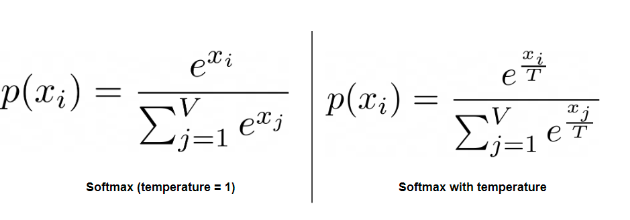

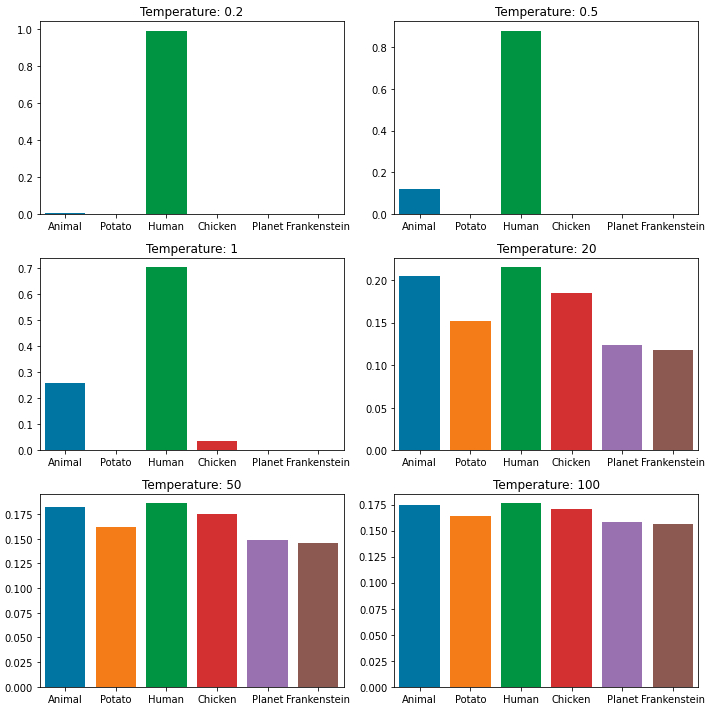

You can toggle between search and sampling via parameter `do_sample`.

For more background on search and sampling, see [this Hugging Face blog post](https://huggingface.co/blog/how-to-generate).

We will illustrate these various options below using our summarization pipeline.

In [36]:
# We previously called the summarization pipeline using the default inference configuration.
# This does greedy search.
summarizer(xsum_sample["document"][0])

[{'summary_text': 'the full cost of damage in Newton Stewart is still being assessed . many roads in peeblesshire remain badly affected by standing water . a flood alert remains in place across the'}]

In [37]:
# We can instead do a beam search by specifying num_beams.
# This takes longer to run, but it might find a better (more likely) sequence of text.
summarizer(xsum_sample["document"][0], num_beams=10)

[{'summary_text': 'the full cost of damage in Newton Stewart is still being assessed . many roads in peeblesshire remain badly affected by standing water . a flood alert remains in place across the'}]

In [38]:
# Alternatively, we could use sampling.
summarizer(xsum_sample["document"][0], do_sample=True)

[{'summary_text': 'the full cost of damage in Newton Stewart is still being assessed . many roads in peeblesshire remain badly affected by standing water . the water breached a retaining'}]

In [39]:
# We can modify sampling to be more greedy by limiting sampling to the top_k or top_p most likely next tokens.
summarizer(xsum_sample["document"][0], do_sample=True, top_k=10, top_p=0.8)

[{'summary_text': 'the full cost of damage in Newton Stewart is still being assessed . many roads in peeblesshire remain badly affected by standing water . a flood alert remains in place across the'}]

### Auto* loaders for tokenizers and models

We have already seen the `dataset` and `pipeline` abstractions from Hugging Face.  While a `pipeline` is a quick way to set up an LLM for a given task, the slightly lower-level abstractions `model` and `tokenizer` permit a bit more control over options.  We will show how to use those briefly, following this pattern:

* Given input articles.
* Tokenize them (converting to token indices).
* Apply the model on the tokenized data to generate summaries (represented as token indices).
* Decode the summaries into human-readable text.

We will first look at the [Auto* classes](https://huggingface.co/docs/transformers/model_doc/auto) for tokenizers and model types which can simplify loading pre-trained tokenizers and models.

API docs:
* [AutoTokenizer](https://huggingface.co/docs/transformers/main/en/model_doc/auto#transformers.AutoTokenizer)
* [AutoModelForSeq2SeqLM](https://huggingface.co/docs/transformers/main/en/model_doc/auto#transformers.AutoModelForSeq2SeqLM)

In [40]:
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM

# Load the pre-trained tokenizer and model.
tokenizer = AutoTokenizer.from_pretrained("t5-small", cache_dir="../working/cache/", device_map='cuda:0')
model = AutoModelForSeq2SeqLM.from_pretrained("t5-small", cache_dir="../working/cache/", device_map='cuda:0')

In [41]:
# For summarization, T5-small expects a prefix "summarize: ", so we prepend that to each article as a prompt.
articles = list(map(lambda article: "summarize: " + article, xsum_sample["document"]))
display(pd.DataFrame(articles, columns=["prompts"]))

,prompts
0,summarize: The full cost of damage in Newton S...
1,summarize: A fire alarm went off at the Holida...
2,summarize: Ferrari appeared in a position to c...
3,"summarize: John Edward Bates, formerly of Spal..."
4,summarize: Patients and staff were evacuated f...
5,summarize: Simone Favaro got the crucial try w...
6,"summarize: Veronica Vanessa Chango-Alverez, 31..."
7,summarize: Belgian cyclist Demoitie died after...
8,"summarize: Gundogan, 26, told BBC Sport he ""ca..."
9,summarize: The crash happened about 07:20 GMT ...


In [42]:
# Tokenize the input
inputs = tokenizer(
    articles, max_length=1024, return_tensors="pt", padding=True, truncation=True
).to('cuda:0')
print("input_ids:")
print(inputs["input_ids"])
print("attention_mask:")
print(inputs["attention_mask"])

input_ids:
tensor([[21603,    10,    37,  ...,     0,     0,     0],
        [21603,    10,    71,  ...,     0,     0,     0],
        [21603,    10, 21945,  ..., 18002,    21,     1],
        ...,
        [21603,    10, 21768,  ...,     0,     0,     0],
        [21603,    10,  9982,  ...,     0,     0,     0],
        [21603,    10,    37,  ...,     0,     0,     0]], device='cuda:0')
attention_mask:
tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 1, 1, 1],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]], device='cuda:0')


In [43]:
# Generate summaries
summary_ids = model.generate(
    inputs.input_ids,
    attention_mask=inputs.attention_mask,
    num_beams=2,
    min_length=0,
    max_length=40,
)
print(summary_ids)

tensor([[    0,     8,   423,   583,    13,  1783,    16, 20126, 16496,    19,
           341,   271, 14841,     3,     5,   186,  7540,    16,   158,    15,
          2296,     7,  5718,  2367, 14621,  4161,    57,  4125,   387,     3,
             5,     3,     9,  8347,  5685,  3048,    16,   286,   640,     8],
        [    0,  1472,  6196,   877,   326,    44,     8,  9108,    86,    29,
            16,  6000,  1887,    30,  1856,     3,     5,  2554,   130,  1380,
            12,  1175,     8,  1595,     3,     5,    80,    13,     8,   192,
         14264,    19,    45, 13692,    63,     6,     8,   119,    45, 20576],
        [    0,     3,   849,  2239,     7,   163, 14014,     3,    60,  8234,
           232,   227,     3, 19585,   643,   845,   150,  8033,    47,   787,
            30,   213,     3,    88,   225,  2447,     3,     5,     3,   849,
          2239,     7,   497,     3,    31,    29,    32,   964,  8033,    47],
        [    0,     8,     3,  3708,    18,  1201

In [44]:
# Decode the generated summaries
decoded_summaries = tokenizer.batch_decode(summary_ids, skip_special_tokens=True)
display(pd.DataFrame(decoded_summaries, columns=["decoded_summaries"]))

,decoded_summaries
0,the full cost of damage in Newton Stewart is s...
1,fire alarm went off at the Holiday Inn in Hope...
2,stewards only handed reprimand after governing...
3,the 67-year-old is accused of committing the o...
4,a man receiving treatment at the clinic threat...
5,Gregor Townsend gave a debut to powerhouse win...
6,"Veronica Vanessa Chango-Alverez, 31, was kille..."
7,the 25-year-old was hit by a motorbike during ...
8,gundogan says he can see the finishing line af...
9,the crash happened about 07:20 GMT at the junc...


### Model-specific tokenizer and model loaders

You can also more directly load specific tokenizer and model types, rather than relying on `Auto*` classes to choose the right ones for you.

API docs:
* [T5Tokenizer](https://huggingface.co/docs/transformers/main/en/model_doc/t5#transformers.T5Tokenizer)
* [T5ForConditionalGeneration](https://huggingface.co/docs/transformers/main/en/model_doc/t5#transformers.T5ForConditionalGeneration)

In [45]:
from transformers import T5Tokenizer, T5ForConditionalGeneration

tokenizer = T5Tokenizer.from_pretrained("t5-small", cache_dir="../working/cache/", device_map='cuda:0')
model = T5ForConditionalGeneration.from_pretrained(
    "t5-small", cache_dir="../working/cache/", device_map='cuda:0'
)

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [46]:
# The tokenizer and model can then be used similarly to how we used the ones loaded by the Auto* classes.
inputs = tokenizer(
    articles, max_length=1024, return_tensors="pt", padding=True, truncation=True
).to('cuda:0')
summary_ids = model.generate(
    inputs.input_ids,
    attention_mask=inputs.attention_mask,
    num_beams=2,
    min_length=0,
    max_length=40,
)
decoded_summaries = tokenizer.batch_decode(summary_ids, skip_special_tokens=True)

display(pd.DataFrame(decoded_summaries, columns=["decoded_summaries"]))

,decoded_summaries
0,the full cost of damage in Newton Stewart is s...
1,fire alarm went off at the Holiday Inn in Hope...
2,stewards only handed reprimand after governing...
3,the 67-year-old is accused of committing the o...
4,a man receiving treatment at the clinic threat...
5,Gregor Townsend gave a debut to powerhouse win...
6,"Veronica Vanessa Chango-Alverez, 31, was kille..."
7,the 25-year-old was hit by a motorbike during ...
8,gundogan says he can see the finishing line af...
9,the crash happened about 07:20 GMT at the junc...


## Summary

We've covered some common LLM applications and seen how to get started with them quickly using pre-trained models from the Hugging Face Hub.  We've also see how to tweak some configurations.

But how did we find those models for our tasks?  In the lab, you will find new pre-trained models for tasks, using the Hugging Face Hub.  You will also explore tweaking model configurations to gain intuition about their effects.

&copy; 2023 Databricks, Inc. All rights reserved.<br/>
Apache, Apache Spark, Spark and the Spark logo are trademarks of the <a href="https://www.apache.org/">Apache Software Foundation</a>.<br/>
<br/>
<a href="https://databricks.com/privacy-policy">Privacy Policy</a> | <a href="https://databricks.com/terms-of-use">Terms of Use</a> | <a href="https://help.databricks.com/">Support</a>